In [2]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os import getcwd
import csv
import tensorflow as tf
import argparse as _argparse
import pandas as pd
import seaborn as sb
import os
import h5py
import random
import glob


from keras.models import Sequential, model_from_json, load_model
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers import Cropping2D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

C:\Users\Willie\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
tf.app.flags._global_parser = _argparse.ArgumentParser() #reset flags
flags = tf.app.flags
FLAGS = flags.FLAGS

#flags.DEFINE_string('data_path', 'drive_data0/driving_log.csv', 'The path to the csv of training data.')
flags.DEFINE_string('save_dir', 'models/', 'The directory to which to save the model.')
flags.DEFINE_integer('batch_size', 128, 'The minibatch size.')
flags.DEFINE_integer('num_epochs', 10, 'The number of epochs to train for.')
flags.DEFINE_float('lrate', 0.00001, 'The learning rate for training.')

In [4]:
import glob
print(glob.glob("driving_log*/*.csv"))

[]


In [5]:
def combine_data():
    paths = glob.glob("drive_data*")
    all_data = pd.DataFrame()
    for path in paths:
        data = pd.read_csv(path + "/" + "driving_log.csv")
        data.columns = ['center', 'left','right','steering','throttle','brake','speed']
        data['file_path'] = path
        all_data = all_data.append(data)   
    return all_data

driving_log = combine_data()

In [6]:
#driving_log = pd.read_csv(FLAGS.data_path) #read in the csv

In [7]:
driving_log.head()

,center,left,right,steering,throttle,brake,speed,file_path
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290,drive_data0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630,drive_data0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011,drive_data0
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419,drive_data0
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236,drive_data0


In [8]:
driving_log.shape

(13543, 8)

In [9]:
angles = driving_log['steering'] #for visualization

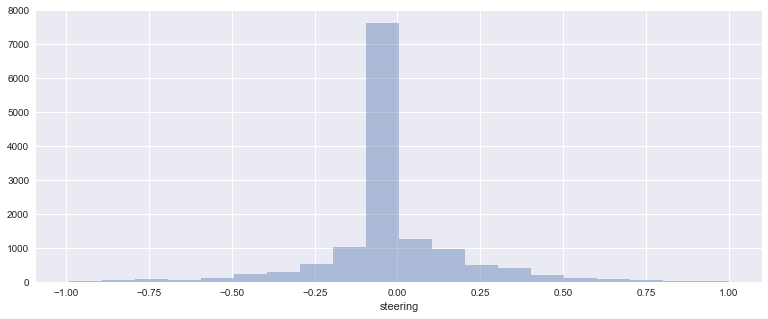

In [10]:
sb.set(rc={'figure.figsize':(13,5)})
sb.distplot(angles, bins=20, kde=False)

In [11]:
def randomly_drop_low_steering_data(data):
    """ Randomly decrease data having
    low steering angle
    """
    index = data[abs(data['steering'])<.05].index.tolist()
    rows = [i for i in index if np.random.randint(10) < 8]
    data = data.drop(data.index[rows])
    print("Dropped %s rows with low steering"%(len(rows)))
    return data

In [12]:
driving_log = randomly_drop_low_steering_data(driving_log)

Dropped 5606 rows with low steering


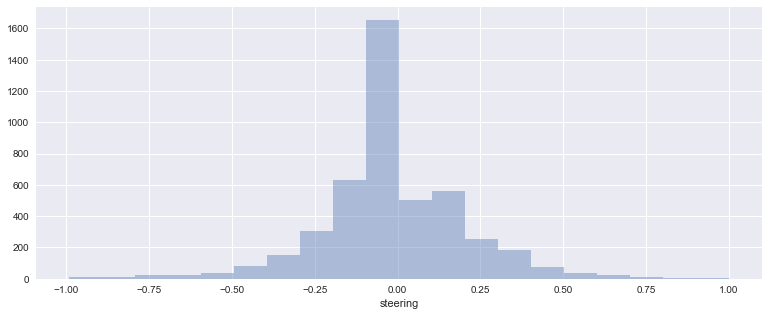

In [13]:
angles = driving_log['steering'] #for visualization
sb.distplot(angles, bins=20, kde=False)

In [14]:
# Split train and validation data
train, test = train_test_split(driving_log, test_size=0.05, random_state=42)

In [15]:
print(train.shape)
print(test.shape)

(4351, 8)
(229, 8)


In [16]:
train.head(20)

,center,left,right,steering,throttle,brake,speed,file_path
2906,IMG/center_2016_12_01_13_37_32_778.jpg,IMG/left_2016_12_01_13_37_32_778.jpg,IMG/right_2016_12_01_13_37_32_778.jpg,0.000000,0.985533,0.0,30.18663,drive_data0
4381,IMG/center_2016_12_01_13_40_02_347.jpg,IMG/left_2016_12_01_13_40_02_347.jpg,IMG/right_2016_12_01_13_40_02_347.jpg,0.090465,0.985533,0.0,30.18628,drive_data0
3651,IMG/center_2016_12_01_13_38_48_278.jpg,IMG/left_2016_12_01_13_38_48_278.jpg,IMG/right_2016_12_01_13_38_48_278.jpg,0.176582,0.000000,0.0,10.84668,drive_data0
575,IMG/center_2016_12_01_13_33_36_500.jpg,IMG/left_2016_12_01_13_33_36_500.jpg,IMG/right_2016_12_01_13_33_36_500.jpg,0.000000,0.985533,0.0,30.18662,drive_data0
6185,IMG/center_2016_12_01_13_43_34_096.jpg,IMG/left_2016_12_01_13_43_34_096.jpg,IMG/right_2016_12_01_13_43_34_096.jpg,-0.373071,0.985533,0.0,30.18020,drive_data0
4071,IMG/center_2016_12_01_13_39_30_863.jpg,IMG/left_2016_12_01_13_39_30_863.jpg,IMG/right_2016_12_01_13_39_30_863.jpg,0.176582,0.793422,0.0,29.36285,drive_data0
2381,C:\Users\Willie\Desktop\driving_data\IMG\cente...,C:\Users\Willie\Desktop\driving_data\IMG\left_...,C:\Users\Willie\Desktop\driving_data\IMG\right...,0.281690,0.000000,0.0,26.70351,drive_data2
5522,IMG/center_2016_12_01_13_42_26_883.jpg,IMG/left_2016_12_01_13_42_26_883.jpg,IMG/right_2016_12_01_13_42_26_883.jpg,-0.211667,0.985533,0.0,30.18462,drive_data0
7012,IMG/center_2016_12_01_13_44_57_985.jpg,IMG/left_2016_12_01_13_44_57_985.jpg,IMG/right_2016_12_01_13_44_57_985.jpg,-0.278127,0.985533,0.0,30.18413,drive_data0
2228,IMG/center_2016_12_01_13_36_24_064.jpg,IMG/left_2016_12_01_13_36_24_064.jpg,IMG/right_2016_12_01_13_36_24_064.jpg,0.052191,0.985533,0.0,30.18658,drive_data0


In [17]:
#nvidia model
def create_model_nvidia():
    """Define the CNN architecture"""
    model = Sequential()  
    
    # Normalize  
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(66, 200, 3)))
    
    #crop
    #model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    #model.add(Lambda(resize_images, input_shape=(66, 200, 3)))
    
    # Add three 5x5 convolution layers (output depth 24, 36, and 48), each with 2x2 stride  
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001)))  
    model.add(ELU())  
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001)))  
    model.add(ELU())  
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001)))  
    model.add(ELU())  
    #model.add(Dropout(dropout))
    
    # Add two 3x3 convolution layers (output depth 64, and 64)  
    model.add(Convolution2D(64, 3, 3, border_mode='valid', W_regularizer=l2(0.001)))  
    model.add(ELU())  
    model.add(Convolution2D(64, 3, 3, border_mode='valid', W_regularizer=l2(0.001)))  
    model.add(ELU())  
    
    # Add a flatten layer  
    model.add(Flatten())  
    
    # Add three fully connected layers (depth 100, 50, 10 neurons respectively), elu activation
    model.add(Dense(100, W_regularizer=l2(0.001)))  
    model.add(ELU())  
    
    #model.add(Dropout(dropout))
    model.add(Dense(50, W_regularizer=l2(0.001)))  
    model.add(ELU())  
    
    #model.add(Dropout(dropout))
    model.add(Dense(10, W_regularizer=l2(0.001)))  
    model.add(ELU())  
    
    #model.add(Dropout(dropout))
    # Add a fully connected output layer  
    model.add(Dense(1))  
    # Compile and train the model,   
    model.compile(optimizer="adam", loss="mse")
    
    return model

In [18]:
#commaai model
def create_model_commaai():
    """Define the CNN architecture"""
    
    ch, row, col = 3, 160, 320  # camera format
    model = Sequential()  
    
    #normalize
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")
    
    return model

In [19]:
def random_brightness(image):
    """
    Returns an image with a random degree of brightness.
    :param image: Image represented as a numpy array.
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    brightness = .75 + np.random.uniform()/2
    #print(brightness)
    image[:,:,2] = image[:,:,2] * brightness
    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    return image

In [20]:
def preprocess_image(image):
    """
    Returns an image after applying several preprocessing functions.
    :param image: Image represented as a numpy array.
    """
    image = image[40:-20,:] #crop image
    image = random_brightness(image) #add random brightness adjustment
    image = cv2.resize(image, (200, 66), interpolation=cv2.INTER_AREA) #resize image
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    return image

(66, 200, 3)


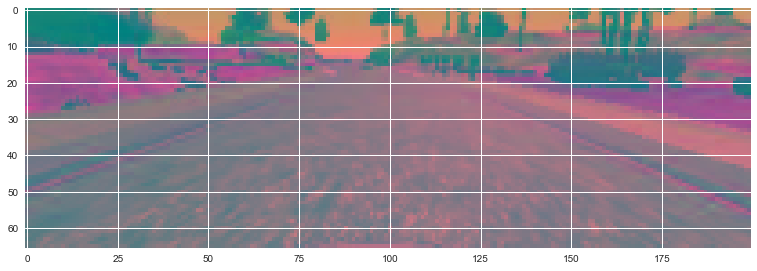

In [21]:
#inspect an random image
index = np.random.randint(0,train.shape[0]-1)
name = train.iloc[index][0].split('/')[-1].split('\\')[-1]
path_root = train.iloc[index][7]
path = path_root + '/IMG/' + name
image = cv2.imread(path)
image = preprocess_image(image)
plt.imshow(image)
print(image.shape)

In [27]:
#build the generator
def generator(samples, batch_size=32):
    """
    samples: a pandas dataframe containing training sample
    batch_size: the batch size
    """
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples.iterrows(): #convert to pd dataframe to iterable
                #print(batch_sample)
                random = np.random.randint(4)
                if random in [0,1]: #center image
                    image_name = batch_sample[1][0]
                    angle_adj = 0

                elif random == 2: #left
                    image_name = batch_sample[1][0]
                    angle_adj = .25
                    
                elif random == 3: #right
                    image_name = batch_sample[1][0]
                    angle_adj = -.25
                
                image_name = image_name.split('/')[-1].split('\\')[-1]
                
                path_root = batch_sample[1][7]
                path = path_root + '/IMG/' + image_name
                
                image = cv2.imread(path)
                image = preprocess_image(image)
                
                angle = float(batch_sample[1][3]) + angle_adj
               
                # Flip image and apply opposite angle with probability of .5
                if np.random.randint(2) == 1:
                    image = cv2.flip(image, 1)
                    angle = -angle
                
                images.append(image)
                angles.append(angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [28]:
if __name__=="__main__":
    tf.app.flags._global_parser = _argparse.ArgumentParser() #reset flags
    flags = tf.app.flags
    FLAGS = flags.FLAGS
    
    flags.DEFINE_string('data_path', 'drive_data0/driving_log.csv', 'The path to the csv of training data.')
    flags.DEFINE_string('save_dir', 'models/', 'The directory to which to save the model.')
    flags.DEFINE_integer('batch_size', 128, 'The minibatch size.')
    flags.DEFINE_integer('num_epochs', 10, 'The number of epochs to train for.')
    flags.DEFINE_float('lrate', 0.00001, 'The learning rate for training.')
    
    driving_log = combine_data() #read in all the csvs
    driving_log = randomly_drop_low_steering_data(driving_log)

    # Split train and validation data
    train, test = train_test_split(driving_log, test_size=0.05, random_state=42)
    
    # compile and train the model using the generator function
    train_generator = generator(train, batch_size=32)
    validation_generator = generator(test, batch_size=32)

    #build the model
    # model = create_model_nvidia()
    # model.compile(loss='mse', optimizer='adam')
    history_object = model.fit_generator(train_generator, #save the model object so you can run analysis on it later
                        samples_per_epoch= len(train), 
                        validation_data=validation_generator, 
                        nb_val_samples=len(test), 
                        nb_epoch=1)

    #save the model
    if not os.path.exists(FLAGS.save_dir):
        os.makedirs(FLAGS.save_dir)

    json = model.to_json()
    #model.save_weights(os.path.join(FLAGS.save_dir, 'model.h5'))
    model.save(os.path.join(FLAGS.save_dir, 'model.h5'))
    with open(os.path.join(FLAGS.save_dir, 'model.json'), 'w') as f:
        f.write(json)
    

Dropped 5533 rows with low steering
Epoch 1/1


C:\Users\Willie\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:29: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\Willie\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:29: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_steps=234, validation_data=<generator..., epochs=1, steps_per_epoch=4436)`


4436/4436 [==============================] - 352s 79ms/step - loss: 0.0684 - val_loss: 0.0584


In [ ]:
###visualizing the loss

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
"""
ideas to improve....

get more data (recovery driving)
add more preprocessing (shifts, shadows, horizon shift)
debug the pipeline (cropping?  rgb?) - DONE

test out someone elses model / pipeline and use transfer learning (lol)

drive.py needs to be modified to preprocess the image
"""

In [ ]:
"""
visualization ideas:
rgb vs bgr vs yuv

"""

In [24]:
"""transfer learning"""
model = create_model_nvidia()
model.load_weights('models/model.h5')

C:\Users\Willie\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="valid", kernel_regularizer=<keras.reg..., strides=(2, 2))`
C:\Users\Willie\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="valid", kernel_regularizer=<keras.reg..., strides=(2, 2))`
C:\Users\Willie\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), padding="valid", kernel_regularizer=<keras.reg..., strides=(2, 2))`
C:\Users\Willie\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid", kernel_regularizer=<keras.reg...)`
C:\Users\Willie\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipyk

In [25]:
json = model.to_json()
model.save_weights(os.path.join(FLAGS.save_dir, 'model.h5'))
model.save(os.path.join(FLAGS.save_dir, 'model.h5'))
with open(os.path.join(FLAGS.save_dir, 'model.json'), 'w') as f:
    f.write(json)